# Discrete dataset. 


$$\dot{x_{1}} = \mu x_{1}$$

$$\dot{x_{2}} = \lambda (x_{2} - x_{1}^{2})$$

### The goal is to discover a coordinate transformation g(x) where the dynamical system is linear. 

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from data.Data import DataMaker
from datetime import date    
from tensorflow import keras
from return_stats import *
from create_plots import *
import pickle
import time

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [23]:
training_data = pickle.load(open('./data/dataset_discrete.pkl', 'rb'))
input_data = training_data.data_val

In [24]:
np.shape(input_data)

(10000, 2, 251)

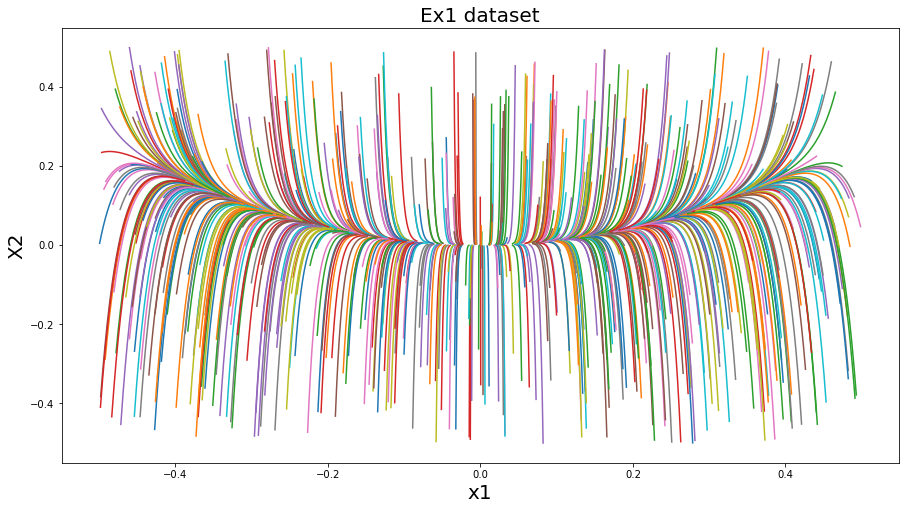

In [25]:
_ = plt.figure(figsize=(15,8))
for ii in np.arange(0, 10000, 15):
    x1 = input_data[ii, 0, :]
    x2 = input_data[ii, 1, :]
    _ = plt.plot(x1, x2, '-')
_ = plt.xlabel("x1", fontsize=20)
_ = plt.ylabel("X2", fontsize=20)
_ = plt.title("Ex1 dataset", fontsize=20)

In [26]:
def dmd_loss(x_data):
    x_minus = x_data[:, :-1]
    x_plus = x_data[:, 1:]

    U, S, Vt = np.linalg.svd(x_minus, full_matrices=True)

    I = np.identity(np.shape(Vt)[0])

    VVt = np.matmul(np.transpose(Vt), Vt)

    for_norm = np.linalg.norm(np.matmul(x_plus, (I - VVt)), ord='fro')
    
    return for_norm**2

In [27]:
for_vec_x = np.zeros(np.shape(input_data)[0])

In [28]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    loss = dmd_loss(training_data.data_val[ii])
    for_vec_x[ii] = loss

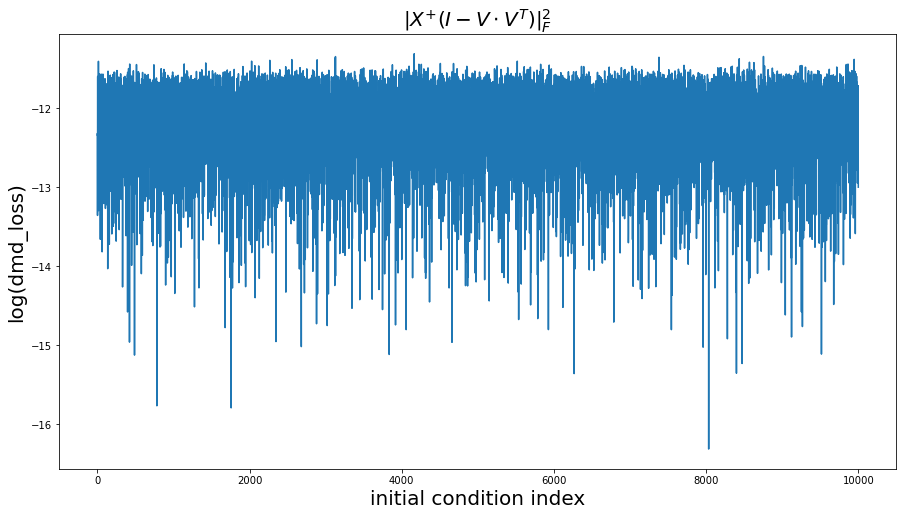

In [29]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(np.log10(for_vec_x))
_ = plt.ylabel("log(dmd_loss)", fontsize=20)
_ = plt.xlabel("initial condition index", fontsize=20)
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$", fontsize=20)


# y-coordinates. Analytic solution for the Koopman space. 

In [30]:
for_vec_y = np.zeros(np.shape(input_data)[0])
new_data = np.zeros((np.shape(input_data)[0], 3, np.shape(input_data)[-1]))

In [31]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    x_data = training_data.data_val[ii]
    y_data = np.zeros((1+np.shape(x_data)[0], np.shape(x_data)[1]))
    
    x1 = x_data[0]
    x2 = x_data[1]
    x3 = x1**2
    
    y_data[0] = x1
    y_data[1] = x2
    y_data[2] = x3
    
    new_data[ii] = y_data
    
    loss = dmd_loss(y_data)
    for_vec_y[ii] = loss

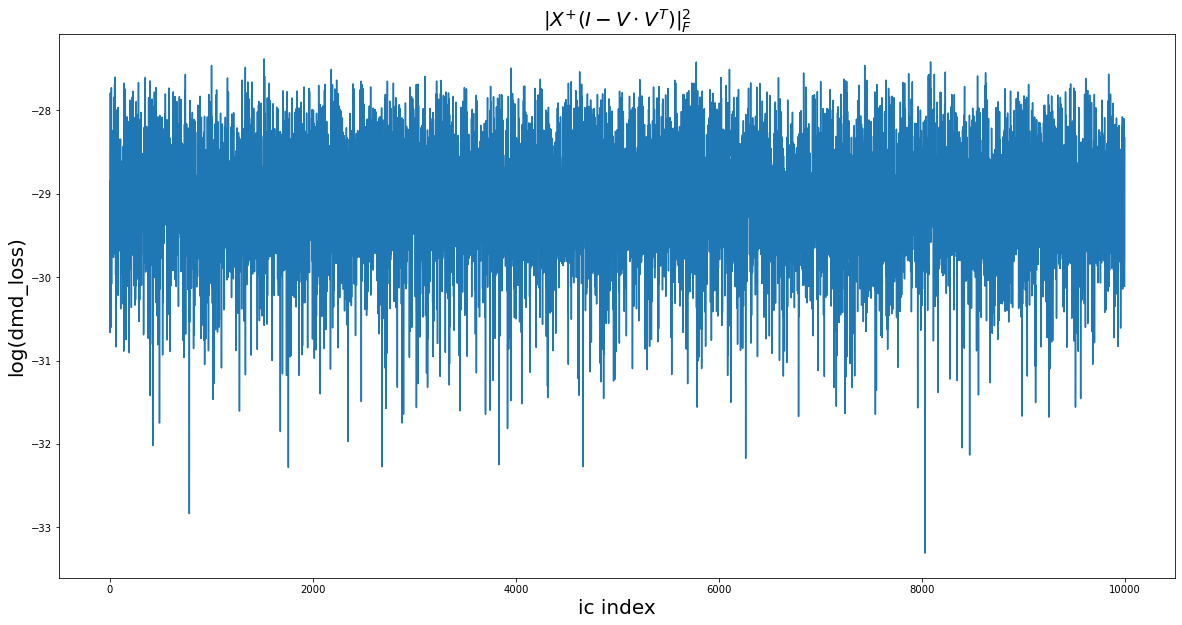

In [32]:
_ = plt.figure(figsize=(20,10))
_ = plt.plot(np.log10(for_vec_y[1:]))
_ = plt.ylabel("log(dmd_loss)", fontsize=20)
_ = plt.xlabel("ic index", fontsize=20)
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$", fontsize=20)

# Train DMD autoencoder. 

In [33]:
# Network Hyper Parameters.
hyp_params = dict()
hyp_params['num_t_steps'] = training_data.params['num_time_steps']
hyp_params['phys_dim'] = training_data.params["num_physical_dim"]
hyp_params['num_init_conds'] = training_data.params['num_initial_conditions']
hyp_params['batch_size'] = 256
hyp_params['num_epochs'] = 200

# Encoding/Decoding Layer Parameters.
hyp_params['num_en_layers'] = 4
hyp_params['num_en_neurons'] = 50
hyp_params['latent_dim'] = 3
hyp_params['window_size'] = 256

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'

hyp_params['c1'] = 1  # coefficient auto-encoder loss.
hyp_params['c2'] = 1  # coefficient of dmd loss.
hyp_params['c3'] = 1  # coefficient of pred loss.

# save results in the folder " Results/save_folder"- including loss curves and plot latent data.
save_folder = "AeEx1_" + str(date.today().isoformat()) 

# number of initial conditions in training and testing dataset.
hyp_params['num_init_conds_training'] = int(0.8 * hyp_params['num_init_conds'])
hyp_params['num_init_conds_test'] = hyp_params['num_init_conds'] - hyp_params['num_init_conds_training']

# initialize machine and loss objects.
myMachine = DMDMachine(hyp_params)
myLoss = LossFunction(hyp_params)

# Learning rate initialization.
hyp_params["initial_learning_rate"] = 3e-3  # MAJOR PARAMETER CHOICE
hyp_params["esteps"] = 80  # MAJOR PARAMETER CHOICE
count = 0

# clear previous run session.
tf.keras.backend.clear_session()

In [34]:
# ======================================================================================================================
# Prepare dataset. 
# ======================================================================================================================
# shuffle the dataset and then divide to training vs testing data sets. 80% training .20% testing.
data_train, data_test= train_test_split(input_data, test_size=0.2, random_state=42)

print("dimensions of training dataset (ic x phys_dim x timesteps) = ", np.shape(data_train))
print("dimensions of testing dataset (ic x phys_dim x timesteps) = ", np.shape(data_test))

dimensions of training dataset (ic x phys_dim x timesteps) =  (8000, 2, 251)
dimensions of testing dataset (ic x phys_dim x timesteps) =  (2000, 2, 251)


In [35]:
# ======================================================================================================================
# Unit test to verify that testing and training datasets are disjoint.
# ======================================================================================================================
for ic_train in data_train:
    for ic_test in data_test:
        if ic_test[:, 0][0] == ic_train[:, 0][0] and ic_test[:, 0][1] == ic_train[:, 0][1]\
        and ic_test[:, 0][2] == ic_train[:, 0][2]:
            print("Testing and Training datasets intersect!")
            print(ic_test[:, 0])

In [36]:
# convert datasets from numpy to tensorflow.
data_train =  tf.data.Dataset.from_tensor_slices(data_train)
data_test =  tf.data.Dataset.from_tensor_slices(data_test)

In [37]:
# create folder to save results.
create_new_folders(save_folder)

# save hyperparams in a json file.
save_hyp_params_in_json(hyp_params=hyp_params, json_file_path=os.path.join("results", save_folder, "hyp_params.txt"))

In [38]:
# ======================================================================================================================
# Load previously trained model as the intitial weights + biases. 
# ======================================================================================================================
load_prev = True 

if load_prev: 
    myMachine.autoencoder.encoder = keras.models.load_model("./models/encAeEx1_2020-12-16", compile=False)
    myMachine.autoencoder.decoder = keras.models.load_model("./models/decAeEx1_2020-12-16", compile=False)

In [39]:

# initialize loss results (lists) as a function of epoch (iteration).
train_loss_results = []
test_loss_results = []

train_dmd_loss = []
test_dmd_loss = []

train_ae_loss = []
test_ae_loss = []

train_pred_loss = []
test_pred_loss = []

epoch = 0

while epoch < (hyp_params['num_epochs']):
    #start timer. 
    start_time = time.process_time()
    # save the total loss of the training data and testing data.
    epoch_loss_avg_train = tf.keras.metrics.Mean()
    epoch_loss_avg_test = tf.keras.metrics.Mean()

    # keep track of individual losses as well, aka dmd loss and ae loss.
    epoch_loss_dmd_train = tf.keras.metrics.Mean()
    epoch_loss_dmd_test = tf.keras.metrics.Mean()

    epoch_loss_ae_train = tf.keras.metrics.Mean()
    epoch_loss_ae_test = tf.keras.metrics.Mean()

    epoch_loss_pred_train = tf.keras.metrics.Mean()
    epoch_loss_pred_test = tf.keras.metrics.Mean()

    # Build out the batches within a given epoch.
    train_batch = data_train.shuffle(hyp_params['num_init_conds_training'], seed=42).batch(hyp_params["batch_size"],
                                                                                           drop_remainder=True)

    test_batch = data_test.shuffle(hyp_params['num_init_conds_test'], seed=42).batch(hyp_params["batch_size"],
                                                                                     drop_remainder=True)

    # Learning rate scheduling plan.  See Ch. 11 of O'Reilly.
    if epoch % hyp_params["esteps"] == 0:
        hyp_params['lr'] = (.2 ** count) * hyp_params["initial_learning_rate"]
        adam_optimizer = tf.keras.optimizers.Adam(hyp_params['lr'])
        count += 1

    # Iterate through all the batches within an epoch.
    for batch_training_data in train_batch:
        # normalize batch

        # Build terms that we differentiate (i.e. loss) and that we differentiate with respect to.
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            predictions_train = myMachine(batch_training_data)
            ae_loss = predictions_train[3]
            dmd_loss = predictions_train[2]
            pred_loss = predictions_train[5]

            loss_train = myLoss(batch_training_data, predictions_train)

            if epoch % 5 == 0:
                if abs((tf.reduce_min(predictions_train[1][:, 0, :]) - tf.reduce_max(
                        predictions_train[1][:, 0, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[1][:, 1, :]) - tf.reduce_max(
                    predictions_train[1][:, 1, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[0][:, 0, :]) - tf.reduce_max(
                    predictions_train[0][:, 0, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[0][:, 1, :]) - tf.reduce_max(
                    predictions_train[0][:, 1, :])).numpy()) < 0.3:
                    print("restart initializers. ")
                    epoch = -1
                    tf.keras.backend.clear_session()
                    myMachine = DMDMachine(hyp_params)
                    myLoss = LossFunction(hyp_params)

        # Compute gradients and then apply them to update weights within the Neural Network
        gradients = tape.gradient(loss_train, myMachine.trainable_variables)
        adam_optimizer.apply_gradients([
            (grad, var)
            for (grad, var) in zip(gradients, myMachine.trainable_variables)
            if grad is not None
        ])

        # Keep track of the loss after each batch.
        epoch_loss_avg_train.update_state(loss_train)
        epoch_loss_ae_train.update_state(ae_loss)
        epoch_loss_dmd_train.update_state(dmd_loss)
        epoch_loss_pred_train.update_state(pred_loss)

    for batch_test_data in test_batch:
        predictions_test = myMachine(batch_test_data)
        dmd_test = predictions_test[2]
        ae_test = predictions_test[3]
        pred_test = predictions_test[5]

        loss_test = myLoss(batch_test_data, predictions_test)

        epoch_loss_avg_test.update_state(loss_test)
        epoch_loss_ae_test.update_state(ae_test)
        epoch_loss_dmd_test.update_state(dmd_test)
        epoch_loss_pred_test.update_state(pred_test)

    train_loss_results.append(epoch_loss_avg_train.result())
    test_loss_results.append(epoch_loss_avg_test.result())

    train_dmd_loss.append(epoch_loss_dmd_train.result())
    train_ae_loss.append(epoch_loss_ae_train.result())
    train_pred_loss.append(epoch_loss_pred_train.result())

    test_dmd_loss.append(epoch_loss_dmd_test.result())
    test_ae_loss.append(epoch_loss_ae_test.result())
    test_pred_loss.append(epoch_loss_pred_test.result())

    if epoch % 15 == 0:
        # save plots in results folder. Plot the latent space, ae_reconstruction, and input_batch.
        create_plots(batch_training_data, predictions_train, hyp_params, epoch, train_loss_results, save_folder, "train")
        create_plots(batch_test_data, predictions_test, hyp_params, epoch, test_loss_results, save_folder, "test")

    if epoch % 10 == 0:
        # plot latent, input and reconstructed ae latest batch data.
        try:
            print_status_bar(epoch, hyp_params["num_epochs"], epoch_loss_avg_train.result(),
                             epoch_loss_avg_test.result(), time.process_time() - start_time,
                             log_file_path=os.path.join("results", save_folder, "log.txt"))
        except Exception:
            print("print status failed.")

    if epoch % 50 == 0 and epoch != 0:
        # plot loss curves.
        create_plots_of_loss(train_dmd_loss, train_ae_loss, test_dmd_loss, test_ae_loss, train_pred_loss,
                             test_pred_loss, myLoss.c1, myLoss.c2, myLoss.c3, epoch, save_folder)


        # save current machine.
        myMachine.autoencoder.encoder.save(os.path.join("models", "enc" + save_folder), save_format='save_weights')
        myMachine.autoencoder.decoder.save(os.path.join("models", "dec" + save_folder), save_format='save_weights')


    epoch += 1

# final summary of the network, again for diagnostic purposes.
myMachine.summary()

restart initializers. 
0/200 ,loss_train: 0.018725755 , loss_test: 0.003710584, run time = 588.46875 sec.
10/200 ,loss_train: 0.00013538999 , loss_test: 0.0001268372, run time = 518.765625 sec.
20/200 ,loss_train: 6.8380024e-05 , loss_test: 6.487131e-05, run time = 500.953125 sec.
30/200 ,loss_train: 6.832047e-05 , loss_test: 3.8159404e-05, run time = 554.390625 sec.
40/200 ,loss_train: 6.01798e-05 , loss_test: 0.00014416594, run time = 552.96875 sec.
50/200 ,loss_train: 4.7481e-05 , loss_test: 2.9353216e-05, run time = 587.734375 sec.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

KeyboardInterrupt: 